In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [57]:
import tensorflow as tf
import tensorlayer as tl
from tensorlayer.layers import *
from models.baseline_model import ConvLSTM_Model
# from preprocess.data_reader import data_reader
from preprocess.cvt2tfrecord import png_cvter

from IPython.core.debugger import set_trace
from pathlib import Path
from tqdm import tqdm_notebook
from functools import partial
from matplotlib import pyplot as plt

# tfrecord

In [3]:
PATH = Path('../data')
path_trn_1 = PATH/'SRAD2018_TRAIN_001'
path_tfrecord = PATH/'train_001.tfrecords'

## Create tfrecord

In [4]:
%%time
cvt = png_cvter(file_name=str(path_tfrecord), data_dir = str(path_trn_1))
cvt.convert_sequence()

CPU times: user 12 s, sys: 8.05 s, total: 20.1 s
Wall time: 22.2 s


## Decode tfrecord

In [4]:
sess = tf.InteractiveSession()

In [46]:
def parser_train(serialized_example):
    features = {
        'data_raw': tf.FixedLenFeature([], tf.string),
        'label_raw': tf.FixedLenFeature([], tf.string)
    }
    features, sequence_features = tf.parse_single_sequence_example(
        serialized_example, context_features={
            'time_stamp': tf.FixedLenFeature([], tf.string),
        }, sequence_features={
            "data_raw": tf.FixedLenSequenceFeature([], dtype=tf.string),
            "label_raw": tf.FixedLenSequenceFeature([], dtype=tf.string),
        })
    cast_to_float32 = partial(tf.cast, dtype=tf.float32)
    
    x = tf.map_fn(tf.image.decode_png, sequence_features['data_raw'], dtype=tf.uint8,
                  back_prop=False, swap_memory=False, infer_shape=False)
    x = tf.map_fn(cast_to_float32, x, dtype=tf.float32,
                  back_prop=False, swap_memory=False, infer_shape=False)
    x = tf.squeeze(x)
    
    y = tf.map_fn(tf.image.decode_png, sequence_features['label_raw'], dtype=tf.uint8,
                  back_prop=False, swap_memory=False, infer_shape=False))
    y = tf.map_fn(cast_to_float32, y, dtype=tf.float32,
                  back_prop=False, swap_memory=False, infer_shape=False))
    y = tf.squeeze(y)
    
    return x, y, features['time_stamp']

In [47]:
batch_size = 2

filenames = tf.placeholder(tf.string)
# filenames = tf.constant(str(path_tfrecord), dtype=tf.string)
dataset = tf.data.TFRecordDataset(filenames)
dataset = dataset.map(parser_train).repeat()
iterator = dataset.make_initializable_iterator()

In [48]:
training_filenames = [str(path_tfrecord)]
sess.run(iterator.initializer, feed_dict={filenames: training_filenames})
x, y, time_stamp = iterator.get_next()

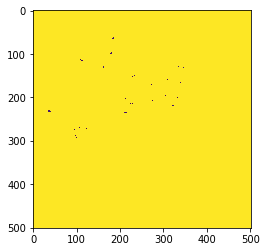

In [62]:
plt.imshow(x.eval()[28] / 255)